In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
import os

In [2]:
os.chdir(r'd:\ml\временные ряды')
data = pd.read_csv("SBER_210301_240421.csv", delimiter =';')

In [3]:
data.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<CLOSE>,<VOL>
0,SBER,D,01/03/21,0,273.58,35741070
1,SBER,D,02/03/21,0,279.10,71481180
2,SBER,D,03/03/21,0,278.01,64113880
3,SBER,D,04/03/21,0,274.75,91841080
4,SBER,D,05/03/21,0,277.50,83301590


In [4]:
data['date'] = pd.to_datetime(data['<DATE>'], dayfirst=True)
data = data.drop(columns=['<TICKER>','<DATE>', '<TIME>', '<VOL>','<TICKER>', '<PER>'])
data = data.rename(columns={'<CLOSE>': 'close'})
data = data[-500:]
data.head()

C:\Users\yuril\AppData\Local\Temp\ipykernel_1784\2952821470.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['<DATE>'], dayfirst=True)


,close,date
280,128.80,2022-04-29
281,123.20,2022-05-04
282,124.80,2022-05-05
283,123.10,2022-05-06
284,123.34,2022-05-11


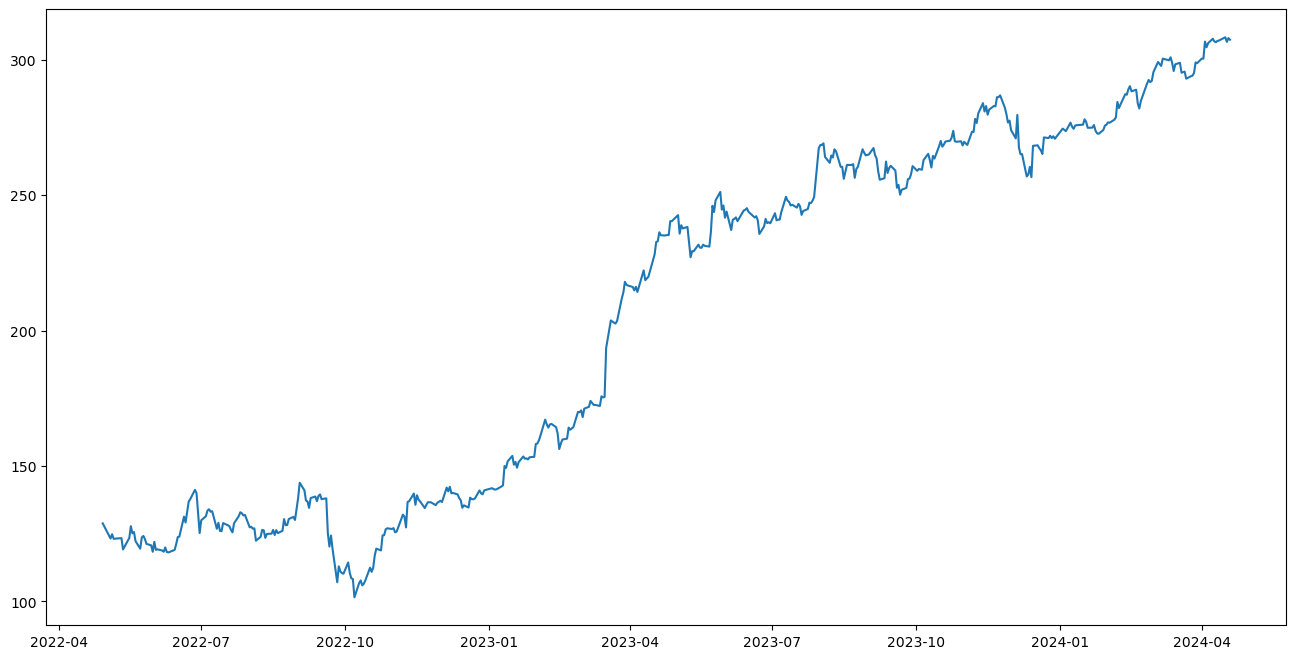

In [5]:
# строим график
import matplotlib.dates as mdates
months = mdates.MonthLocator()
days = mdates.DayLocator()
timeFmt = mdates.DateFormatter('%Y-%m')
plt.figure(figsize=(16, 8))
plt.plot(data['date'], data['close'])
plt.show()

In [6]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [7]:
i = 1

In [8]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [9]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    i= 0
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [10]:
def plot_tema(alpha, beta, gamma, ser=data["close"], ser_to_plot=data["close"], n_preds=24, t=data['date']):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema,color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [11]:
ts = data['close'].to_list()
tx = data['date'].to_list()

In [12]:
len(ts), len (tx)

(500, 500)

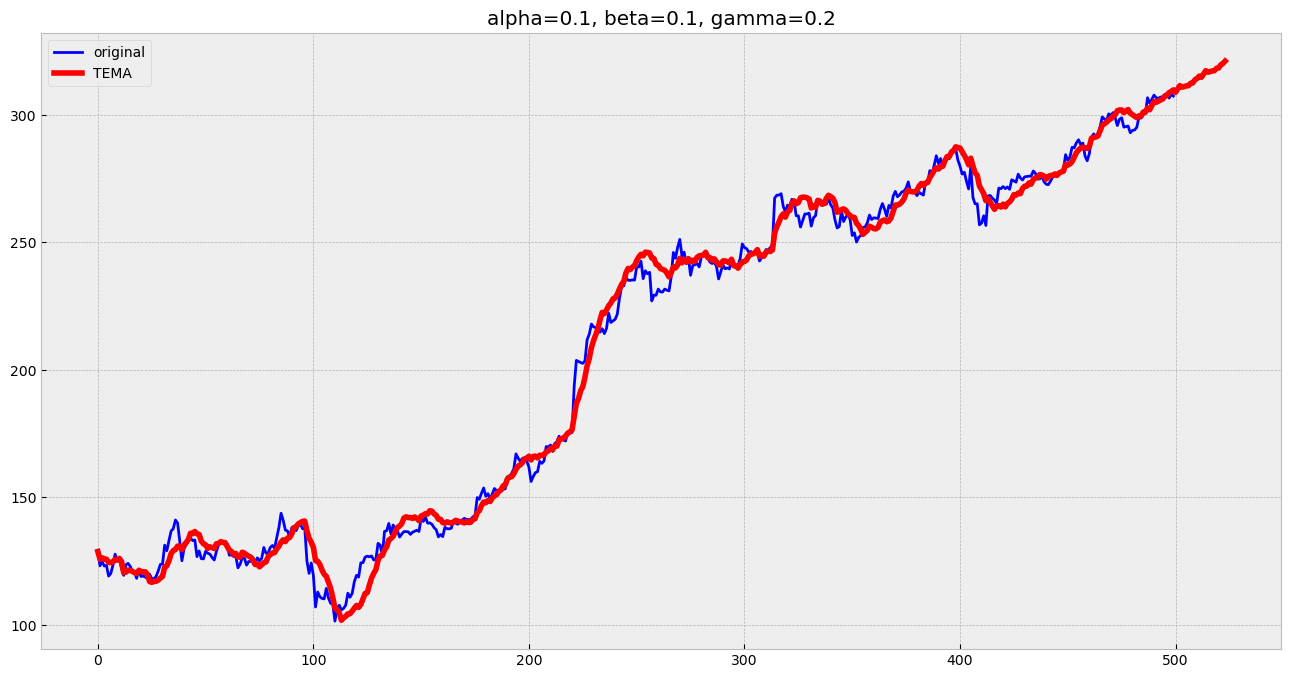

In [13]:
plot_tema(0.1, 0.1, 0.2, ser=ts,ser_to_plot=ts, t = tx)

# Подбор параметров

Что значит, что наша модель лучше всего приближает исходные данные? Это значит, что минимизируется некоторая функция ошибки. Мы, для простоты, будет считать стандарнтый RMSE:

$RMSE =  \sqrt {1/n \sum^N_{i=1} (\hat{y}_i - y_i)^2}$

Алгоритм поиска стандартный - метод градиентного спуска. Считаем производный по каждому из параметров и спускаемся в сторону минимума.

In [14]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [15]:
series = ts

In [16]:
train, test, val = series[:400], series[400:450], series[450:]

In [17]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [18]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [19]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 150.25167424247545
        x: [ 1.000e+00  0.000e+00  1.000e+00]
      nit: 1
      jac: [-3.282e+02  7.007e+04 -0.000e+00]
     nfev: 8
     njev: 2
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


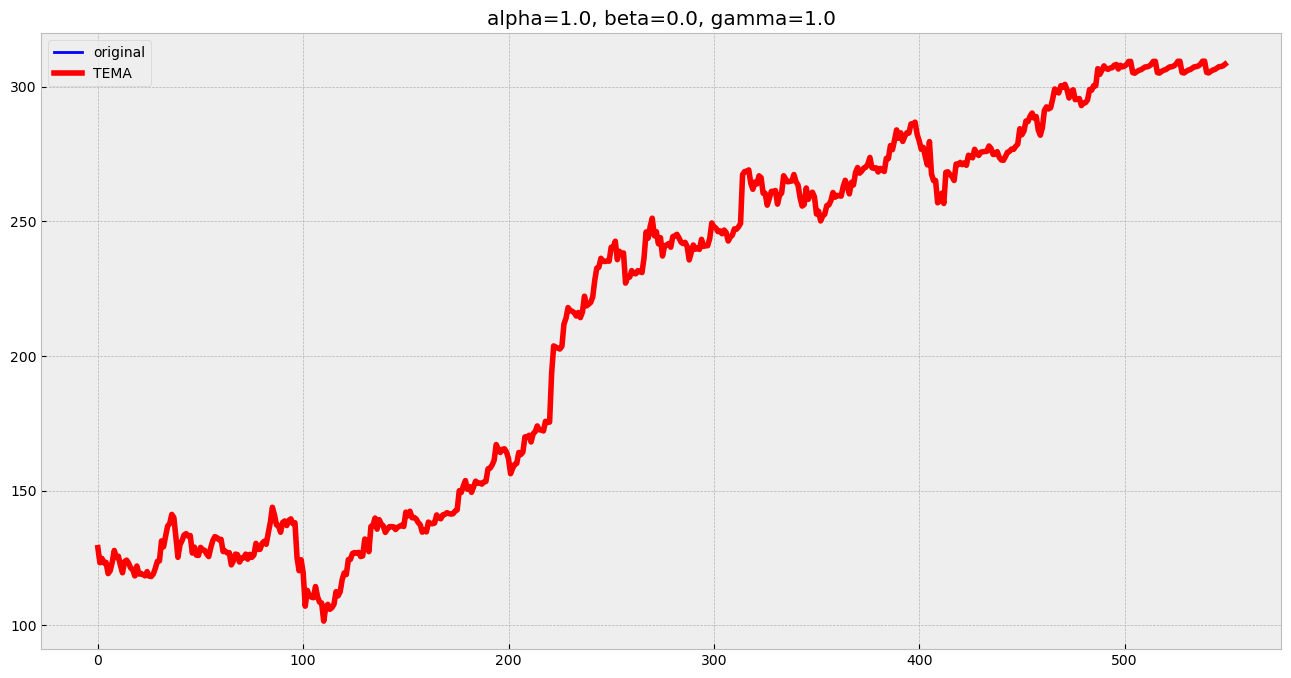

In [20]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:500], ser_to_plot=series, n_preds=len(val))